In [0]:
try:
    from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU
    from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, UpSampling2D, Conv2D,Conv2DTranspose
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras import backend as K
except: 
    from keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU
    from keras.layers import BatchNormalization, Activation, ZeroPadding2D, UpSampling2D, Conv2D,Conv2DTranspose
    from keras.models import Sequential, Model
    from keras.optimizers import Adam
    from keras import backend as K
import tensorflow as tf

import os
import argparse
import glob 

from PIL import Image
import matplotlib.pyplot as plt

import sys

import numpy as np

class DCGAN():
    def __init__(self, img_rows=64, img_cols=64, channels=3, latent_dim=100, loss='binary_crossentropy', name='shipibo_64'):
        self.name = name

        # Input shape
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = latent_dim
        self.loss = loss

        self.optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()

        # Build the generator
        self.generator = self.build_generator()

        # Build the GAN
        self.build_combined()
        
    def build_combined(self):
        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.loss, optimizer=self.optimizer)    
    
    def load_weights(self, generator_file=None, discriminator_file=None):

        if generator_file:
            generator = self.build_generator()
            generator.load_weights(generator_file)
            self.generator = generator
    
        if discriminator_file:
            #discriminator = self.build_discriminator()
            self.discriminator.load_weights(discriminator_file)
            #self.discriminator = discriminator

        if generator_file or discriminator_file: 
            self.build_combined() 

        print("loaded model weights")

    def build_generator(self):

        model = Sequential()
        #model.add(Dense(128, activation="relu", input_dim=self.latent_dim, name="generator_input") )
        #model.add(Dropout(0.1))
        
        #4,4
        model.add(Dense(512 * 4 * 4, activation="relu", input_dim=self.latent_dim, name="generator_input") )
        model.add(Dropout(0.30))
        model.add(Reshape((4, 4, 512)))
        

        #8,8
        model.add(Conv2DTranspose(256, kernel_size=4,strides=(2,2), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        

        16,16
        model.add(Conv2DTranspose(128, kernel_size=4,strides=(2,2), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.20))
       
        

        #32,32
        model.add(Conv2DTranspose(64, kernel_size=4,strides=(2,2), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        
        
        #64,64
        model.add(Conv2DTranspose(self.channels, kernel_size=4,strides=(2,2), padding="same", activation="tanh", name="generator_output"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img, name="generator")

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(64, kernel_size=5, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.35))

        model.add(Conv2D(256, kernel_size=5, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.35))

        model.add(Conv2D(512, kernel_size=5, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.35))
        
        """ remove for 64 version
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        """
        model.add(Flatten())

        #model.add(Dense(32, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        
        img = Input(shape=self.img_shape)
        validity = model(img)

        discrim = Model(img, validity)

        

        discrim.compile(loss='binary_crossentropy',
            optimizer=self.optimizer,
            metrics=['accuracy'])

        return discrim

    
    def normalize_images(self,im):
        return ((im + 1)/2.0)


    def train(self, X_train, epochs, batch_size=128, save_interval=100,batch_sample=5):

        # Adversarial ground truths


        #fixed noise points for using train images

        fixed_noise = np.random.normal(0, 1, ( 9 , self.latent_dim)) # generate 9 points
        train_imgs = []

        for epoch in range(epochs):
            
            #noisy labels for improved training
            #check if this has an effect on disc accuracy?
            valid = np.ones((batch_size, 1)) - np.random.uniform(low=0.0, high=0.1, size=(batch_size, 1))
            fake = np.zeros((batch_size, 1)) + np.random.uniform(low=0.0, high=0.1, size=(batch_size, 1))
            
            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            if epoch % 10 == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            if epoch % batch_sample == 0:
                #work on training animation
                epoch_imgs = self.generator.predict(fixed_noise)
                train_imgs.append(self.normalize_images(epoch_imgs)) 

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs( "images/{}_{:05d}.png".format(self.name,epoch) )
                # self.combined.save_weights("combined_weights ({}).h5".format(self.name)) # https://github.com/keras-team/keras/issues/10949
                self.generator.save("generator ({}).h5".format(self.name))
                self.discriminator.save("discriminator ({}).h5".format(self.name))


        return train_imgs

    def save_models(self):
        self.generator.save("generator ({}).h5".format(self.name))
        self.discriminator.save("discriminator ({}).h5".format(self.name))

    def save_imgs(self, name=''):
        r, c = 4, 4
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))

        # replace the first two latent variables with known values
        #for i in range(r):
        #    for j in range(c):
        #        noise[4*i+j][0] = i/(r-1)-0.5
        #        noise[4*i+j][1] = j/(c-1)-0.5

        gen_imgs = self.generator.predict(noise)
        gen_imgs = self.normalize_images(gen_imgs)

        fig, axs = plt.subplots(r, c, figsize=(6.72,6.72))
        plt.subplots_adjust(left=0.05,bottom=0.05,right=0.95,top=0.95, wspace=0.2, hspace=0.2)

        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i,j].axis('off')
                cnt += 1

        if name:
            fig.savefig(name, facecolor='white' )
        else: 
            fig.savefig('{}.png'.format(self.name), facecolor='black' )

        plt.close()
    

def export_model(saver, model, model_name, input_node_names, output_node_name):
    from tensorflow.python.tools import freeze_graph
    from tensorflow.python.tools import optimize_for_inference_lib
    
    if not os.path.exists('out'):
        os.mkdir('out')

    tf.train.write_graph(K.get_session().graph_def, 'out', model_name + '_graph.pbtxt')

    saver.save(K.get_session(), 'out/' + model_name + '.chkp')

    freeze_graph.freeze_graph('out/' + model_name + '_graph.pbtxt', None, False,
                              'out/' + model_name + '.chkp', output_node_name,
                              "save/restore_all", "save/Const:0",
                              'out/frozen_' + model_name + '.bytes', True, "")

    input_graph_def = tf.GraphDef()
    with tf.gfile.Open('out/frozen_' + model_name + '.bytes', "rb") as f:
        input_graph_def.ParseFromString(f.read())

    output_graph_def = optimize_for_inference_lib.optimize_for_inference(
            input_graph_def, input_node_names, [output_node_name],
            tf.float32.as_datatype_enum)

    with tf.gfile.FastGFile('out/opt_' + model_name + '.bytes', "wb") as f:
        f.write(output_graph_def.SerializeToString())

    print("graph saved!")



In [28]:
#load dataset
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


os.chdir("/content/drive/My Drive/GAN/Shipibo GAN/")
!ls

Mounted at /content/drive
 animation
 anim_grid_2.mp4
 anim_grid_3.mp4
 anim_grid_dcgan_128.mp4
 anim_grid_dcgan_64_2.mp4
 anim_grid_dcgan_64.mp4
 anim_grid.mp4
'Attempts and results.gdoc'
'Copy of copy of DCGAN artificial art from github 64.ipynb'
'copy of DCGAN artificial art from github.ipynb'
'DCGAN 128.ipynb'
'discriminator (shipibo_128).h5'
'discriminator (shipibo_64_black).h5'
'discriminator (shipibo_64).h5'
'discriminator (shipibo_64_white).h5'
'discriminator (shipibo).h5'
'generator (shipibo_128).h5'
'generator (shipibo_64_black).h5'
'generator (shipibo_64).h5'
'generator (shipibo_64_white).h5'
'generator (shipibo).h5'
 images
 imgs_128
 imgs_32
 imgs_64
 preproc
'Shipibo GAN 32 V2.ipynb'
'Shipibo GAN 64 V2.ipynb'
 test_gif_128.mp4
 test_gif_2.mp4
 test_gif_64.mp4
 test_gif_black_64.mp4
 test_gif_white_64.mp4
 train_grid.mp4
 V1
'W DCGAN 64.ipynb'


https://github.com/googlecolab/colabtools/issues/287#issuecomment-517446876

measures when vm wont synch with drive



In [0]:
#drive.flush_and_unmount()

In [9]:

!mkdir imgs_64
!unzip -q preproc/64/0_compressed_64.zip -d imgs_64/


mkdir: cannot create directory ‘imgs_64’: File exists
replace imgs_64/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [10]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


In [11]:
from keras.preprocessing.image import load_img,img_to_array
from PIL import Image

def load_images(path,size=64,final_size=0):
    """ loads images into a numpy array and returns them
    """
    img_paths = [path + f  for f in os.listdir(path)]

    print(len(img_paths))

    if final_size== 0:
        final_size = len(img_paths)

    dataset_shape = (final_size ,size,size,3)

    data = np.ndarray(shape=dataset_shape)

    for i,f in enumerate(img_paths):
        with Image.open(f) as im:
            
            im = np.array(im)
            
            if i % 500 == 0:
                print("loaded ", i,"images" )

            data[i] = im.astype(int)

            if (i+1) % final_size == 0:

                return data
            
    print(data.shape)

    return data

data = load_images("imgs_64/",final_size=0)

#normalize data to tanh dim
data  = (data - 127.5) / 127.5

Using TensorFlow backend.


14700
loaded  0 images
loaded  500 images
loaded  1000 images
loaded  1500 images
loaded  2000 images
loaded  2500 images
loaded  3000 images
loaded  3500 images
loaded  4000 images
loaded  4500 images
loaded  5000 images
loaded  5500 images
loaded  6000 images
loaded  6500 images
loaded  7000 images
loaded  7500 images
loaded  8000 images
loaded  8500 images
loaded  9000 images
loaded  9500 images
loaded  10000 images
loaded  10500 images
loaded  11000 images
loaded  11500 images
loaded  12000 images
loaded  12500 images
loaded  13000 images
loaded  13500 images
loaded  14000 images
loaded  14500 images


In [0]:
from matplotlib import animation

def animate_single_frame(train_imgs,index=0):
    

    ims = []
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1], frameon=False, aspect=1)
    ax.set_xticks([]); ax.set_yticks([])

    for train_ims in train_imgs:

        

        im_1 = plt.imshow(train_ims[0,:,:],vmin=0, vmax=1, animated=True) #add first image for test
        
        ims.append([im_1])
        #plt.pause(0.1) 

    mp4_writer =  animation.writers['ffmpeg']
    writer = mp4_writer(fps=24, metadata=dict(artist='Me'), bitrate=1800)


    anim = animation.ArtistAnimation(fig,ims)
    anim.save("test_gif_white_64.mp4", writer= writer)



In [13]:
preload_model = True

dcgan =  DCGAN(latent_dim=128) #create class

if preload_model:
    dcgan.load_weights(generator_file="generator (shipibo_64).h5",discriminator_file="discriminator (shipibo_64).h5")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 17, 17, 128)       0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 17, 17, 128)       512       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 17, 17, 128)      

In [54]:


train_imgs = dcgan.train(data,epochs=20000,batch_size=64,batch_sample=20)

animate_single_frame(train_imgs)

0 [D loss: 0.203784, acc.: 0.00%] [G loss: 0.223471]
10 [D loss: 0.207271, acc.: 0.00%] [G loss: 0.203914]
20 [D loss: 0.199223, acc.: 0.00%] [G loss: 0.206328]
30 [D loss: 0.205816, acc.: 0.00%] [G loss: 0.203440]
40 [D loss: 0.202640, acc.: 0.00%] [G loss: 0.199452]
50 [D loss: 0.210995, acc.: 0.00%] [G loss: 0.223427]
60 [D loss: 0.197332, acc.: 0.00%] [G loss: 0.209080]
70 [D loss: 0.205219, acc.: 0.00%] [G loss: 0.195013]
80 [D loss: 0.198646, acc.: 0.00%] [G loss: 0.194472]
90 [D loss: 0.206109, acc.: 0.00%] [G loss: 0.221933]
100 [D loss: 0.207767, acc.: 0.00%] [G loss: 0.205576]
110 [D loss: 0.186032, acc.: 0.00%] [G loss: 0.189951]
120 [D loss: 0.207023, acc.: 0.00%] [G loss: 0.203161]
130 [D loss: 0.185342, acc.: 0.00%] [G loss: 0.199301]
140 [D loss: 0.205670, acc.: 0.00%] [G loss: 0.211232]
150 [D loss: 0.202032, acc.: 0.00%] [G loss: 0.208834]
160 [D loss: 0.183844, acc.: 0.00%] [G loss: 0.179515]
170 [D loss: 0.199532, acc.: 0.00%] [G loss: 0.202156]
180 [D loss: 0.186289

KeyboardInterrupt: ignored

<function matplotlib.pyplot.show>

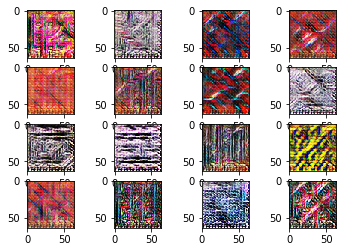

In [30]:

noise = np.random.normal(0, 1, ( 16 , dcgan.latent_dim)) # generate 9 points
imgs = dcgan.normalize_images(dcgan.generator.predict(noise))

for i in range(len(noise)):
    
    plt.subplot(4,4, i+1)
    plt.imshow(imgs[i])

plt.show


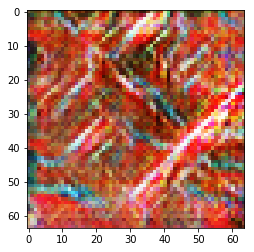

In [60]:
noise = np.random.randn(1,dcgan.latent_dim)
im = dcgan.normalize_images(dcgan.generator.predict(noise))

plt.imshow(im[0])

plt.show()



In [0]:


# starting point for every image
seed_start = np.random.normal(0, 1, (9, dcgan.latent_dim))

# these parameters will change every time step
latentSpeed = np.random.normal(3, 1, (9, dcgan.latent_dim))
vary = np.copy(seed_start)

# video settings
time = 0
fps = 30
maxTime = 30 # seconds
frameCount = 0

anim_imgs = []

while (time <= maxTime):

    # for each image
    for i in range(len(seed_start)): 
        
        # change the latent variables
        for j in range(dcgan.latent_dim):
            vary[i][j] = seed_start[i][j] + np.sin( 2*np.pi*(time/maxTime) * latentSpeed[i][j] ) 

    gen_imgs = dcgan.generator.predict(vary)

    anim_imgs.append(dcgan.normalize_images(gen_imgs))
    

    frameCount += 1
    time += 1/fps

(3, 3)


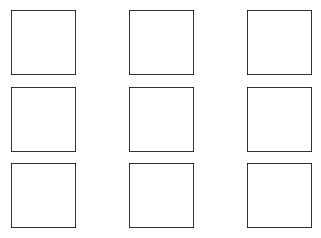

In [53]:
from matplotlib import animation

fig,axs = plt.subplots(3,3)

print(axs.shape)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

images = []

#iterate ove images
for imgs in anim_imgs:
    ims = [] 
    for i,img in enumerate(imgs):
        
        line = i%3
        col = int(i/3)
        ims.append(axs[line,col].imshow(img[:,:],vmin=0, vmax=1, animated=True))
    
    images.append(ims)

mp4_writer =  animation.writers['ffmpeg']
writer = mp4_writer(fps=24, metadata=dict(artist='Me'), bitrate=1800)

anim = animation.ArtistAnimation(fig,images)
anim.save("anim_grid_dcgan_64_2.mp4", writer= writer)

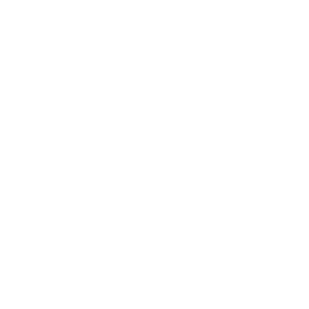

In [70]:
from IPython.display import HTML

ims = []
fig = plt.figure()
ax = fig.add_axes([0,0,1,1], frameon=False, aspect=1)
ax.set_xticks([]); ax.set_yticks([])

for train_ims in anim_imgs:

    

    im_1 = plt.imshow(train_ims[4,:,:],vmin=0, vmax=1, animated=True) #add first image for test
    
    ims.append([im_1])
    #plt.pause(0.1) 

#mp4_writer =  animation.writers['ffmpeg']
#writer = mp4_writer(fps=24, metadata=dict(artist='Me'), bitrate=1800)

fps=30

anim = animation.ArtistAnimation(fig,ims,interval=(1/fps)*1000)
HTML(anim.to_html5_video())